# Les données de rendement de la production d'avoine par région en Ontario




<img style='float:right;' width='250px' src='https://ontariograinfarmer.ca/wp-content/uploads/2017/09/gluten-free-oats-1024x576.jpg'>


Des données présentant les rendements de production d'avoine pour différentes régions de l'Ontario sont disponibles sur le site ontarien:


<a href="https://data.ontario.ca/dataset/ontario-field-crop-area-and-production-estimates-by-county">
https://data.ontario.ca/dataset/ontario-field-crop-area-and-production-estimates-by-county
</a>



    



* Les données disponibles ont été collectées pour la période de 2004 à 2022.  
* Les données sont accessibles sous la forme d'un fichier Excel.  
* Le fichier Excel contient plusieurs onglets, un par année. 
* Ce sont des données numériques et chronologiques.

<p>
<a href='https://data.ontario.ca/dataset/ontario-field-crop-area-and-production-estimates-by-county'>
<img  src='https://drive.google.com/uc?export=view&id=1lirh_gkQatPcBZKXtpgWYBHQ2Ba-lzCs' width='600px'></a>
<span>&nbsp&nbsp&nbsp&nbsp</span>
    



Voici à quoi ressemble ce fichier Excel : 

<img alt='Ontario_Avoine_Excel.png' src='https://drive.google.com/uc?export=view&id=1q2-DHgVFVHZ7vMQtQR5RuVw_oWgKuciq' width='800px'>



### Qu'est-ce que le rendement ?


Le rendement est défini comme suit:   $ Rendement = \frac {Production}{Acres_{récoltées}} *1000$

où le $Rendement$ est en boisseaux à l'acre.


C'est donc le nombre de boisseaux produits par acre récoltée.  Ici, on ne s'intéresse pas aux nombres d'acres ensemencées.  On ne cherche pas à caractériser le ratio récoltée/ensemencée.



## Installation et chargement des librairies python

Nous devons d'abord charger (et possiblement installer) les librairies nécessaires.  

Voici une description de certaines des librairies utilisées.

- `os` permet d'utiliser des fonctions liées aux fichiers sur disque et au système d'exploitation.
- `re` pour utiliser des expressions régulières
- `matplotlib` et `seaborn` pour générer des graphiques
- `numpy` pour des opérations d'algèbres linéaires et mathématiques
- `pandas` pour faciliter la manipulation et la structure des données (parfois lent pour les gros jeux de données)

In [1]:
# Accéder à des fichiers sur Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/My Drive/

In [2]:
# Installation et chargement des librairies requise
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

#!pip install ydata_profiling ipywidgets
#!pip install --upgrade Pillow

from ydata_profiling import ProfileReport
colors = ["#40BEAD", "#248CC4", "#308E81", "#576AC9"]  # couleurs palette IVADO

## Chargement des données de rendement d'avoine

Nous chargeons ensuite en mémoire les données provenant du fichier Excel décrit plus haut. La librairie `pandas`nous permet de lire directement un fichier Excel.  

La fonction `pd.read_excel()` lit un onglet à la fois.  Nous utilisons plutôt `pd.ExcelFile()` pour gérer les onglets (`sheet_names`). 

In [3]:
# Nous allons chercher le fichier directement via l'URL
filepath = "https://data.ontario.ca/dataset/e30dc044-5f75-4f33-b63e-6326f8769bea/resource/5fe1b9cc-5c3b-4f8f-99fc-2cacf41fcf9d/download/ctyoats_f.xlsx"
f = pd.ExcelFile(filepath)
sheet_names = f.sheet_names

# Nous imprimons les noms des onglets du fichier Excel pour se familiariser avec les données
print(f'{len(sheet_names)} onglets dans le fichier: {os.path.basename(filepath)}')
print('--------------------')
print(", ".join(sheet_names))

Le fichier contient 19 onglets.

Ce n'est pas pratique d'avoir les données dans 19 structures de données séparées (onglets). 
Concaténons les données des différents onglets.  

Nous ferons ceci en deux étapes dans ce notebook pour pouvoir les regarder individuellement.  
Nous pourrions le faire en une seule étape (dans un script par exemple): 

1. Nous allons itérer parmi tous les onglets et conserver les `dataframe` de `pandas` dans un dictionnaire. 
2. Nous allons concaténer les différents `dataframe` en un seul.


In [4]:
# Lecture de tous les onglets du fichier Excel.  
# Nous les conservons dans un dictionnaire de dataframes pandas pour l'instant.
dfs = {}
for sheet in sheet_names:  
    df = f.parse(sheet, skiprows=1)
    df.loc[:, 'Onglet'] = sheet 
    dfs[sheet] = df
    print(F'{sheet} : {df.shape[0]} rangées, {df.shape[1]} colonnes,  {list(df.columns)}')

### À votre tour 

<img style='float:right;'  src='https://drive.google.com/uc?export=view&id=1HMGzZe3dGBk9Zgpk0tKtbQarFu3WMrBK' width='100px'>  </a>

C'est une bonne pratique de regarder les données souvent : les premières rangées comme les dernières.
Inspecter différents onglets, le début et la fin.  Noter vos observations.



In [5]:
# à votre tour

In [6]:
# Inspection de quelques onglets dans le fichier
i = 1
dfs[sheet_names[i]].head(5)

### Observations    
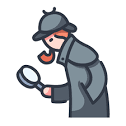


<ul style='font-size:20px'>
<li>L'année peut être récupérée dans les noms d'onglet.</li>

<li>Chaque onglet contient les données d'une année donnée.</li>

<li>Les onglets ne comportent pas tous le même nombre de rangées et deux onglets contiennent des erreurs dans leur nom.</li>

<li>Tous les onglets ont le même nombre de colonnes.</li>

<li>Le header n'est pas toujours dans la première rangée, il est parfois dans la seconde.</li>
<li>La colonne contenant les régions n'est pas nommée.</li>

</ul>



<ul style='font-size:20px'>
<li>Incohérence de langue (FR/EN) (oats).</li>

<li>Incohérence dans le nombre de lignes entre les onglets.</li>

<li>Incohérence dans le nom des régions entre les onglets.</li>

<li>Incohérence dans le nom des colonnes entre les onglets.</li>

<li>Incohérence pour indiquer l'absence de données ou l'absence d'ensemencement (on ne sait pas ce que signifie '-', 'x', 0). </li>
    
<li>Logiquement, un rendement de 0 semble improbable si les valeurs d'acres ensemencées et d'acres récoltées ne sont pas 0. Il faudrait approfondir ceci.</li>

<li>Incohérence dans les valeurs dernières lignes des onglets</li>

<li>Le nom des colonnes a changé au fil du temps.  Au moins, la signification et l'ordre sont restés les mêmes.</li>
</ul>

## Plan de nettoyage

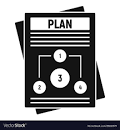

<br>
<span style='font-size:20px'>
La première étape est de gérer les erreurs évidentes pour produire un jeu de données que nous pourrons explorer plus en détails. Pour l'instant, nous ne pouvons procéder à l'EDA avec le jeu de données que nous avons. 
Encore moins intégrer un autre type de données, comme les données météo.
Le processus de nettoyage est un processus itératif.  Nous ne pouvons normalement pas tout corriger du premier coup.
</span>

<span style='font-size:20px'>
Quels sont les étapes ? <br>
    
    
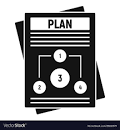


1. Gérer la différence entre le nombre de rangées pour pouvoir concaténer les onglets en une seule structure de données.<br>
<em>
    <ul>
    <li>Nous savons que la dernière ligne de données contient le total pour l'Ontario</li>
    <li>Nous savons que les mots 'Rendement' et 'Production' se trouvent dans la rangée contenant les noms de colonnes (header)</li>
    </ul>
</em><br><br>


2. Standardiser le vocabulaire
<em>
    <ul>
    <li>Nous ne voulons pas garder les mots clés 'Division', 'County',... dans le nom des régions</li>
    
    <li>Nous voulons harmoniser les noms de colonnes</li>
    
    <li>Nous voulons standardiser les valeurs nulles</li>
        </ul>
</em>

</span>


<span style='font-size:20px'>
    
3.  Extraire les années des noms d'onglets et les ajouter aux données<br>
<em>
     <ul>
   <li>Malgré les erreurs dans le nom des onglets, ce qui nous intéresse est l'année que nous voulons conserver</li>
     </ul>
</em><br>


4. Nous voulons combiner les données des différents onglets en une seule matrice.  Ce n'est pas très pratique de travailler avec 19 matrices de données.  
</span>

### Concaténation des dataframes

In [7]:
new_cols = ['Region', 'Acres ensemencée', 'Acres récoltée', "Rendement (boisseaux à l'acre)",
            "Production ('000 boisseaux)", "Production ('000 tonnes métriques)",  "Onglet", "Annee"]

data = pd.DataFrame()
for sheet, df in dfs.items():  
    df['Onglet'] = sheet
    word_in_column = df.columns.str.contains("Production", regex=True).any() # mot-clé pour trouver le header
    if word_in_column == False:
        header = df.iloc[0,:].values # le header se trouve dans la première rangée
        df = df.iloc[1:,:] # les données commencent à la seconde rangée
        df.columns = header
      
    year = int(re.search(r'\d+', sheet).group())
    df['Annee'] = 2010 if year == 201 else year
    
    df.columns = new_cols
    
    last_row_index = df.Region.tolist().index('Ontario')
    df = df.iloc[:last_row_index, :]
    data = pd.concat([data, df], axis=0, ignore_index=True)

In [8]:
data = data.loc[~data.Region.str.contains('Ontario'),:]
data = data.loc[~data.Region.str.contains('Région'),:]
data.replace('-', 0, inplace=True)
data.replace('x', 0, inplace=True)

# Optionnel. Nous pouvons renommer les colonnes pour les rendre plus lisibles avec rename
# Nous aurions pu faire cela dans la boucle plus haut en utilisant ces noms dans new_cols
new_column_names = { "Acres ensemencée": "Ensemencee",
                     "Acres récoltée": "Recoltee",
                     "Rendement (boisseaux à l'acre)": "Rendement",
                     "Production ('000 boisseaux)": "Production_boisseaux",
                     "Production ('000 tonnes métriques)": "Production_tonnes",
                     "Year": "Annee",
                     "Sheet": "Onglet"}

data.rename(columns=new_column_names, inplace=True)

Regardons de quoi a l'air la nouvelle matrice de données.  
Est-ce que les dimensions semblent bien?

In [9]:
print('Dimension du dataframe: ', data.shape)
data.head(2)

In [10]:
data.tail(2)

 ### Uniformisation des noms de régions 
 
Nous avons des noms de régions non uniformes entre les onglets.  Les onglets plus anciens incluent le type de division administrative (County, District, Division, ...)

In [11]:
data.loc[data.Region.str.contains('Brant'),:].tail(5)

#### Comment uniformiser les noms des régions ?

<br>

<span style='font-size:20px'>
  <ul> 
      <li>Retirer les totaux par régions ("Région du Nord de l'Ontario")</li>
   <li>Remplacer les mots : County, Regional Municipality, District, Counties, Division, District Municipality, United Counties</li>
   <li> Que faire avec le Grand ? (Grand Sudbury &rarr; est la ville, Sudbury est le district)</li>
      </ul>
    </span>

In [12]:
# Le code recherche les mots communs à plusieurs régions dans une liste de noms de régions. 
# Il stocke ces mots dans la liste "words" afin de les utiliser plus tard pour nettoyer les noms de région.

regions = data.Region.unique()
words = []
for region in regions:
    found = [r for r in regions if region in r]
    if len(found) > 1:
        print(region, found)
        words += [r.replace(region, '') for r in found if r!=region]
words = list(set(words))

In [13]:
# Le code modifie les noms de région.
# Il utilise la liste de mots extraits précédemment pour supprimer ces mots des noms de région

words.remove('Grand ')
words = sorted(list(set(words)))
words.append(' Municipality')

def clean_region(region):
    for word in words:
        region = region.replace(word, '')
    return region

data.loc[data.Region == 'Sudbury Regional Municipality', 'Region'] = 'Grand Sudbury'
data.loc[:, 'Region'] = data.Region.apply(lambda x: clean_region(x))

## Exploration des données

    
Maintenant que nous avons une matrice de données manipulable, nous allons explorer les données pour mieux les comprendre et corriger les erreurs restantes.

Comment ? En générant des graphiques et des statistiques
    


In [14]:
# Inspection des statistiques des variables 

data[0:-2].describe()

### Visualisation


La meilleure façon de comprendre un jeu de données est en l'explorant à l'aide de graphique.  Il est important d'identifier quelles informations et quels graphiques sont pertinents.  La visualisation doit avoir une intention.


#### Heatmap

Ce graphique met en relation deux variables qualitatives (catégories) (ici, l'année et la région) et une variable continue (ici, le rendement).

In [15]:
mx = data.pivot_table(index="Annee", columns="Region", values="Rendement")
fig = plt.figure(figsize=(12, 5))
sns.heatmap(mx, cmap="GnBu",  linewidths=.5)
plt.show()

Nous pouvons voir que certaines régions ont un rendement de 0 et que certaines régions ont des valeurs manquantes.  

Le rendement semble plus élevé dans les années plus récentes mais il y a beaucoup de valeurs à 0.

Nous pouvons revisiter le heatmap et inclure la valeur de rendement comme annotation.

In [16]:
fig, ax = plt.subplots(figsize=(20,5))
mx = data.pivot(index="Annee", columns="Region", values="Rendement")
sns.heatmap(mx, annot=True, ax=ax, fmt=".0f", cmap='GnBu', linewidths=.5)
plt.title('Rendement par région et par année')
plt.show()

#### Clustermap

Comme le heatmap, le graphique met en relation deux variables catégoriques et une variable continue.

En plus, il présente un clustering hiérarchique des années et des régions basé sur le rendement.  Les années ayant des profils de rendement similaires parmi les régions sont positionnés plus près et les régions ayant des profils de rendement similaires parmi les années sont positionnés plus près.



In [17]:
mx = data.pivot_table(index="Annee", columns="Region", values="Rendement").fillna(0)
sns.clustermap(mx.T, cmap="GnBu",  linewidths=.5, yticklabels=True)
plt.show()    

<span style='font-size:20px'>
Nous observons trois groupes principaux pour les régions, dominés par la présence de valeurs nulles.  Pour les années, il y a 2 groupes, dominés par le même critère.  

 <br>
Il y a donc 11 régions pour lesquelles les valeurs sont manquantes pour la plupart des années (Muskoca, ThunderBay, ...).  Et de 2016 à 2022, il manque plus de données.

Il y a quelques régions qui ont un rendement supérieur à 150.
</span>

#### Pairplot

Ce graphique met en relation deux variables.  Il permet de voir qualitativement si des variables sont corrélées en entre elles en plus de présenter la distribution de chaque variable.  Nous pouvons voir que :



In [18]:
fig = plt.figure(figsize=(10, 4))
sns.pairplot(data)
plt.show()

* la distribution du rendement est bimodale.  
    * il suit une distribution normale 
    * il y une grande proportion de valeurs égales à 0

* le nombre d'acres récoltées est corrélé au nombre d'acres ensemencées.
* la production de boisseaux est proportionnelle au nombre d'acres ensemencées
* le rendement n'est pas corrélé avec les autres variables
* il y a un grand nombre d'entrées à 0

#### Graphes de distribution

L'exploration des différentes variables peut soulever des questions au niveau de la logique.  
Ici, est-ce que c'est normal d'avoir des cas où l'on récolte plus que l'on ensemence? 

L'histogramme du pourcentage d'acres récoltées versus ensemencées montre qu'il y a des cas à investiguer.

In [19]:
fig = plt.figure(figsize=(5, 3))
plt.hist(data["Recoltee"]/data["Ensemencee"]*100, bins=40, color='#2A8CC4'
         , edgecolor='black', linewidth=0.5)

plt.axvline(x=100, c='#40BEAD', linestyle='--')
plt.title("Pourcentage d'acres Recoltées/Ensemencées")
plt.xlabel("Pourcentage (Récoltées/Ensemencées)")
plt.show()

In [20]:
data.loc[(data["Recoltee"] == 0) & (data["Ensemencee"] > 0), :].head()

In [21]:
data.loc[data["Recoltee"] > data["Ensemencee"], :]

In [22]:
# Rendement moyen par region
fig, ax = plt.subplots(figsize=(8, 4))
data.loc[data.Rendement > 0, :].groupby("Region")\
    .agg({"Rendement": "mean"}) \
    .sort_values(by="Rendement", ascending=False) \
    .plot(kind='bar', ax=ax, color=colors[0])
plt.ylabel('Rendement moyen (boisseaux/acre)')
plt.show()

In [23]:
# Nombre d'années pour lesquelles les rendements sont supérieurs à 0
fig, ax = plt.subplots(figsize=(8, 4))
data.loc[data.Rendement > 0, :].groupby("Region") \
            .agg({"Rendement": "count"}) \
            .sort_values(by="Rendement", ascending=False) \
            .plot(kind='bar', ax=ax, color=colors[0])
plt.ylabel("Nombre d'années")
plt.title("Nombre d'années pour lesquelles les rendements sont supérieurs à 0")
plt.show()

#### Boxplot 

Le boxplot nous permet de facilement mettre en relation des distributions.  Nous pouvons donc avoir un aperçu du rendement par région et par année.
Le boxplot présente la valeur médiane et les valeurs quantiles ansi que les valeurs aberrantes de la distribution.

In [24]:
sns.boxplot(data, y='Rendement', x='Annee', color=colors[1])
plt.xticks(rotation=90)
plt.suptitle("Rendement d'avoine par région")
plt.title(f"Les données proviennent de {len(data.Region.unique())} régions", fontsize=10)
plt.show()

In [25]:
fig = plt.figure(figsize=(10, 4))
sns.boxplot(data,  y='Rendement', x='Region', color=colors[1])
plt.xticks(rotation=90)
plt.suptitle("Rendement d'avoine par région")
plt.title("Les données représentées sont de 2004-2022", fontsize=10)
plt.show()

Compte tenu des valeurs manquantes, les boxplots ne nous renseignent que partiellement sur les différences de distributions entre les années et les régions.

#### Graphiques spécifiques

Nous construirons des graphiques particuliers pour répondre à des questions spécifiques.

Par exemple, ici on veut suivre le rendement au fil des ans dans trois régions bien précises.

In [26]:
fig, ax = plt.subplots(figsize=(5,3))

regions = ['Grey', 'Bruce', 'Waterloo']
for i,region in enumerate(regions):
    data.loc[data.Region==region,:].plot(x='Annee', y='Rendement', label=region, marker='o', ax=ax, color=colors[i])

plt.xticks(data.Annee.unique(), rotation=90)
plt.ylabel('Rendement (boisseaux/acre)')
plt.title(f'Rendement - avoine')
plt.ylim(0,data.Rendement.max()+5)
plt.show()

In [27]:
def plot_subset(data, x, y, values, values_col, y_units='', x_units='', capture_plot=False):            
    '''
    Graphique de y en fonction x pour les valeurs spécifiées
    Exemple : 
    plot_subset(data, x='Annee', y='Rendement', values=['Sudbury', 'Grand Sudbury'],
                values_col='Region', y_units='boisseaux/acre')
    '''
    _, ax = plt.subplots(figsize=(5,3))
      
    for value in values :
        tmp = data.loc[data[values_col]==value, :]
        tmp.plot(x=x, y=y, label=value, marker='o', ax=ax)
        
    plt.xticks(data[x].unique(), rotation=90)
    plt.ylim(data[y].min()-5, data[y].max()+5)
    plt.ylabel(f'{y.title()} ({y_units})')
    plt.xlabel(f'{x.title()} ({x_units})')
    plt.title(f'{y.title()} par {values_col.lower()} en fonction de(s) {x.lower()}')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
   
    plt.show()


In [28]:
plot_subset(data, x='Annee', y='Rendement', values=['Sudbury', 'Grand Sudbury'],
                values_col='Region', y_units='boisseaux/acre')

### Exploration avec le ProfileReport

<span style='font-size:20px'>
Cette librairie nous aide à sauver du temps en générant des graphiques standards et des statistiques pour notre jeu de données.


    
Des logiciels comme <a href="https://openrefine.org">OpenRefine</a> et <a href="https://orangedatamining.com">Orange</a> peuvent aussi nous aider à faire l'exploration des données.
    
    
</span>

In [29]:
# Compter environ 20-30 secondes
report = ProfileReport(data, title="Profiling Report")
report

## Sauvegarde du fichier de données nettoyées

<span style='font-size:20px'>

Le processus de nettoyage est un processus itératif.  Nous pouvons sauvegarder une première version des données en sachant que nous y reviendrons au besoin si des problèmes de qualité sont identifiés en aval. 
        
</span>

In [30]:
data.to_csv('rendement_avoine_v1.csv')

## À votre tour
<img style='float:right;'  src='https://drive.google.com/uc?export=view&id=1HMGzZe3dGBk9Zgpk0tKtbQarFu3WMrBK' width='100px'>  </a>


* Quelle autre visualisation pourriez-vous faire pour mieux comprendre les données ? 
* Quelles questions supplémentaires pourraient être posées ?
* Qu'avons-nous oublié de considérer ?


Ce n'est pas tout de créeer des graphiques, il faut aussi les interpréter.  
Pouvez-vous produire un graphique et en tirer une conclusion ou une observation sur les données.
